In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

DATASET_PATH = "Tsunami.csv"
RANDOM_STATE = 42

In [16]:
target = "Number of Runups"
base_columns = [
    "Tsunami Event Validity",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    target,
 ]

tsunami_df = (
    pd.read_csv(DATASET_PATH, usecols=base_columns)
    .dropna(subset=base_columns)
    .reset_index(drop=True)
 )

print("Preprocessed DataFrame shape:", tsunami_df.shape)

Preprocessed DataFrame shape: (1691, 5)


In [17]:
print("Number of Runups statistics:")
print(tsunami_df[target].describe())
print(f"\nUnique values: {tsunami_df[target].nunique()}")
print(
    f"Data is right-skewed: median={tsunami_df[target].median():.0f}, max={tsunami_df[target].max():.0f}"
)

correlations = tsunami_df.corr(numeric_only=True)[target].drop(target)
print("\nCorrelation with Number of Runups:")
for feature, corr in correlations.sort_values(key=abs, ascending=False).items():
    print(f"{feature:25s}: {corr:6.3f}")

Number of Runups statistics:
count    1691.000000
mean       17.991721
std       175.902663
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      6421.000000
Name: Number of Runups, dtype: float64

Unique values: 115
Data is right-skewed: median=2, max=6421

Correlation with Number of Runups:
Earthquake Magnitude     :  0.164
Tsunami Event Validity   :  0.073
Longitude                :  0.008
Latitude                 :  0.005


In [18]:
tsunami_df = tsunami_df.assign(
    Eq_Magnitude_Squared=lambda df: df["Earthquake Magnitude"] ** 2,
    Coastal_Distance=lambda df: np.hypot(df["Latitude"], df["Longitude"]),
    Is_Pacific_Ring=lambda df: ((
        df["Latitude"].between(10, 60)
        & df["Longitude"].between(120, 180)
    )
    | (
        df["Latitude"].between(-60, 10)
        & df["Longitude"].between(-180, -100)
    )).astype(int),
)

feature_columns = [
    "Tsunami Event Validity",
    "Earthquake Magnitude",
    "Eq_Magnitude_Squared",
    "Latitude",
    "Longitude",
    "Coastal_Distance",
    "Is_Pacific_Ring",
]

X = tsunami_df[feature_columns].fillna(0)
y = np.log1p(tsunami_df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
 )

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("Using engineered spatial and magnitude features")

Training set: (1352, 7)
Test set: (339, 7)
Using engineered spatial and magnitude features


In [19]:
search_space = {
    "rf": (
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        {
            "n_estimators": [100, 200, 300],
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    ),
    "gb": (
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5, 10],
        },
    ),
    "xgb": (
        XGBRegressor(
            objective="reg:squarederror",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0,
        ),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "min_child_weight": [1, 3, 5],
        },
    ),
}

def tune_model(name, estimator, params):
    print(f"Tuning {name.upper()}...")
    search = GridSearchCV(
        estimator,
        params,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        verbose=1,
    )
    search.fit(X_train, y_train)
    print(f"Best {name.upper()} params: {search.best_params_}")
    return search.best_estimator_

models = {
    name: tune_model(name, estimator, params)
    for name, (estimator, params) in search_space.items()
}

Tuning RF...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuning GB...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best RF params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuning GB...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best GB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Tuning XGB...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best GB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Tuning XGB...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best XGB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}
Best XGB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}


In [20]:
ensemble = VotingRegressor(list(models.items()))
ensemble.fit(X_train, y_train)

y_pred_log = ensemble.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

r2 = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)

print("\nEnsemble Model Performance (RF + GB + XGB):")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE (log): {rmse_log:.4f}")
print(f"  MAE (log): {mae_log:.4f}")

print("\nOriginal Scale:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f} runups")
print(f"  MAE: {mean_absolute_error(y_true, y_pred):.2f} runups")

print("\nIndividual Model Performance:")
for name, model in models.items():
    preds = model.predict(X_test)
    print(f"  {name.upper()}: R² = {r2_score(y_test, preds):.4f}")


Ensemble Model Performance (RF + GB + XGB):
  R² Score: 0.4101
  RMSE (log): 0.9153
  MAE (log): 0.6363

Original Scale:
  RMSE: 49.96 runups
  MAE: 11.70 runups

Individual Model Performance:
  RF: R² = 0.4435
  GB: R² = 0.3857
  XGB: R² = 0.3729


Top Features:
                  feature  importance
0  Tsunami Event Validity    0.512643
1    Earthquake Magnitude    0.190453
2    Eq_Magnitude_Squared    0.115601
3                Latitude    0.062863
4        Coastal_Distance    0.055225
5               Longitude    0.052428
6         Is_Pacific_Ring    0.010787


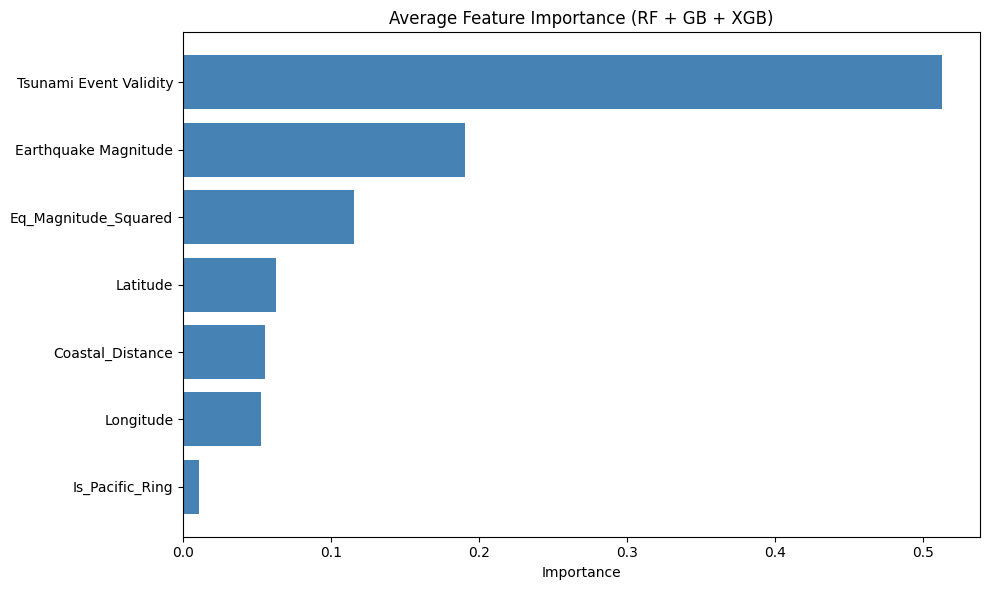

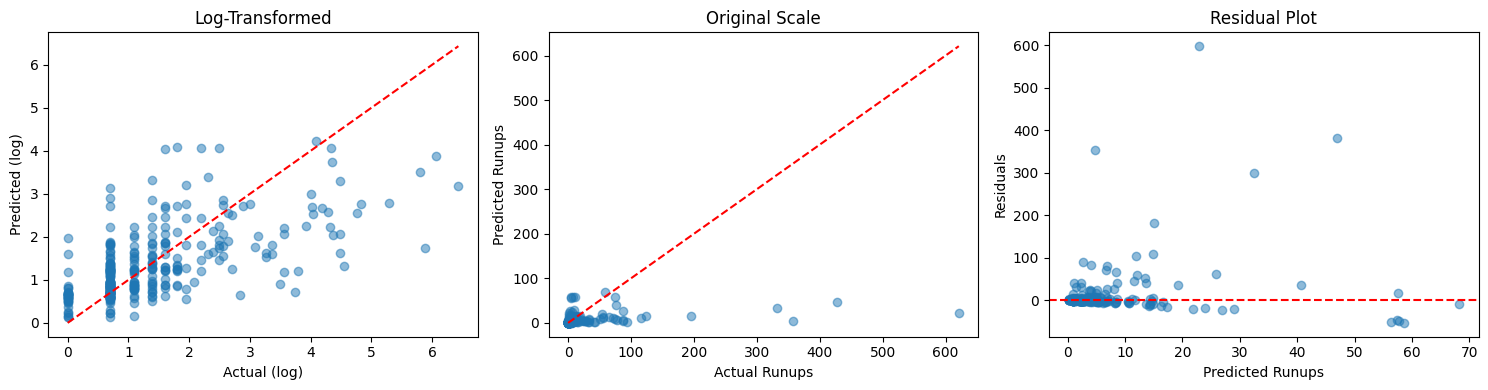


Model Summary:
  Explains 41.0% of variance
  Average error: ±11.7 runups


In [21]:
feature_importances = np.mean(
    [model.feature_importances_ for model in models.values()],
    axis=0,
 )
feature_importance = (
    pd.DataFrame({"feature": feature_columns, "importance": feature_importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
 )

print("Top Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"], color="steelblue")
plt.xlabel("Importance")
plt.title("Average Feature Importance (RF + GB + XGB)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(y_test, y_pred_log, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
axes[0].set_xlabel("Actual (log)")
axes[0].set_ylabel("Predicted (log)")
axes[0].set_title("Log-Transformed")

axes[1].scatter(y_true, y_pred, alpha=0.5)
axes[1].plot([0, y_true.max()], [0, y_true.max()], "r--")
axes[1].set_xlabel("Actual Runups")
axes[1].set_ylabel("Predicted Runups")
axes[1].set_title("Original Scale")

residuals = y_true - y_pred
axes[2].scatter(y_pred, residuals, alpha=0.5)
axes[2].axhline(0, color="r", linestyle="--")
axes[2].set_xlabel("Predicted Runups")
axes[2].set_ylabel("Residuals")
axes[2].set_title("Residual Plot")

plt.tight_layout()
plt.show()

print("\nModel Summary:")
print(f"  Explains {r2 * 100:.1f}% of variance")
print(f"  Average error: ±{mean_absolute_error(y_true, y_pred):.1f} runups")